## Core concepts

In [58]:
%load_ext autoreload
%autoreload 2
import summarization_interface
from summarization_interface import Material, get_idf_value, normalize_word, Default_IDF_Value, LinkType
from pathlib import Path
from summarization_framework import load_rsm

materials, references, output_base_dir = load_rsm()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


load links from rsm: 100%|██████████| 10668/10668 [00:00<00:00, 147873.30it/s]
load file rsm: 3359it [00:00, 1637074.96it/s]


In [140]:
# 对比TFIDF, 在前50%占比情况，词跨度, action_link_count
import re

tf, tf_idf, front, _span, action_counter, incoming_action_counter = {}, {}, {}, {}, {}, {}
for sentence_index, sentence in enumerate(mainMaterial.sentences):
    for word in sentence.words:
        if not re.match('[a-zA-Z]+', word):
            continue

        word = normalize_word(word)
        word = word.replace('-', '')

        if len(word) < 4:
            continue

        tf[word] = tf.get(word, 0) + 1
        tf_idf[word] = tf_idf.get(word, 0) + get_idf_value(word)

        if sentence_index < len(mainMaterial.sentences) / 2:
            front[word] = front.get(word, 0) + 1

        if word not in _span:
            _span[word] = [sentence_index, sentence_index]
        else:
            _span[word][1] = sentence_index

    for pre, ind, rtype, post, _ in sentence.links:
        if rtype == LinkType.Action:
            action_counter[pre] = action_counter.get(pre, 0) + 1
            incoming_action_counter[post] = incoming_action_counter.get(post, 0) + 1

span = {
    word: values[1] - values[0]
    for word, values in _span.items()
}

In [141]:
def _sort_norm(data_list, n):
    norm_data_list = []
    for data in data_list:
        norm_data = {}
        _max, _min = max(data.values()), min(data.values())
        for key, value in sorted(data.items(), key=lambda x: -x[1]):
            norm_data[key] = (value - _min) / (_max - _min)
        norm_data_list.append(norm_data)
        # _sort = lambda d, n: sorted(d.items(), key=lambda x: -x[1])[:n]

    common_top = set(norm_data_list[0].keys())
    for data in norm_data_list[1:]:
        common_top &= set(k for k in data)
    
    return norm_data_list, common_top

norms, common_top = _sort_norm([tf, tf_idf, front, span, action_counter, incoming_action_counter], 20)

# from functools import partial
# sort = partial(_sort, n = 20)

# sort(tf)
# sort(tf_idf)
# sort(front)
# sort(span)
# sort(action_counter)
# sort(incoming_action_counter)

In [142]:
# 找出公共的前20个词，证明action link的优势

norms, common_top = _sort_norm([tf, tf_idf, front, span, action_counter, incoming_action_counter], 20)

norm_tf, norm_tf_idf, norm_front, norm_span, norm_action_counter, norm_incoming_action_counter = norms


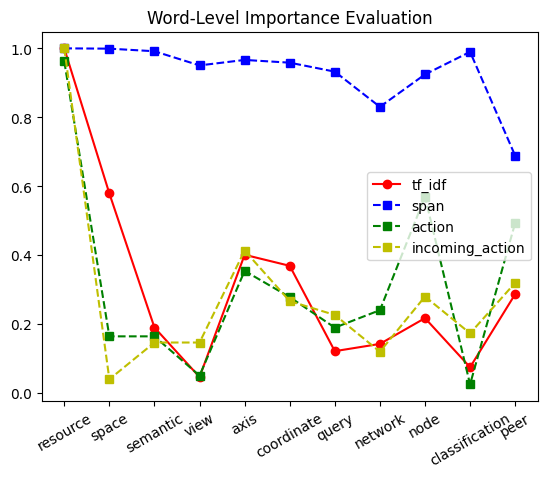

In [144]:
import matplotlib.pyplot as plt
import numpy as np

# 生成横坐标数据
x = np.arange(0, 10, 1)

# TODO: 选一些例子，更能凸显action link的优势
# TODO: semantic node也可以计算frequency, span等 
core_words = [
    'resource',
    'space',
    'semantic',
    # 'link',
    'view',
    'axis',
    'coordinate',
    'query',
    'network',
    'node',
    'classification',
    'peer',
]

# 生成纵坐标数据
tf_idf_y = [norm_tf_idf[w] for w in core_words]
front_y = [norm_front[w] for w in core_words]
span_y = [norm_span[w] for w in core_words]
action_y = [norm_action_counter[w] for w in core_words]
incoming_action_y = [norm_incoming_action_counter[w] for w in core_words]

y1 = np.sin(x)
y2 = np.cos(x)

# 绘制第一条折线
plt.plot(core_words, tf_idf_y, color='r', marker='o', linestyle='-', label='tf_idf')
# 绘制第二条折线
plt.plot(core_words, span_y, color='b', marker='s', linestyle='--', label='span')
plt.plot(core_words, action_y, color='g', marker='s', linestyle='--', label='action')
plt.plot(core_words, incoming_action_y, color='y', marker='s', linestyle='--', label='incoming_action')

# 添加图例
plt.legend()

plt.xticks(rotation=30)

# 设置x轴标签
# plt.xlabel('x')
# 设置y轴标签
# plt.ylabel('y')
# 设置标题
plt.title('Word-Level Importance Evaluation')

plt.savefig('figs/word_level_importance.png', dpi=300, bbox_inches='tight')


# 显示图形
plt.show()


In [25]:
get_idf_value('finer'), Default_IDF_Value

(4.33, 7.513607609220388)

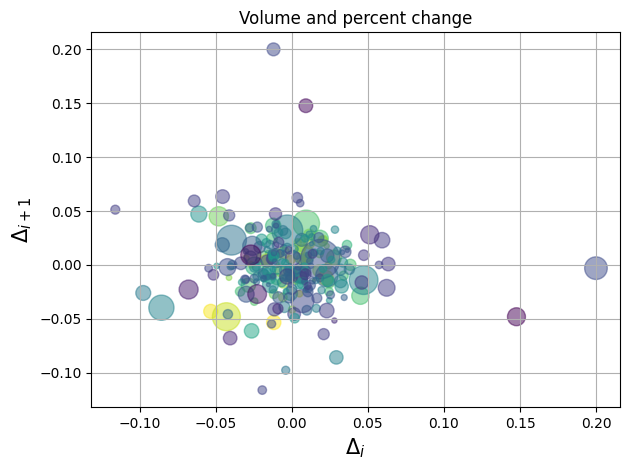

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.cbook as cbook

# Load a numpy record array from yahoo csv data with fields date, open, high,
# low, close, volume, adj_close from the mpl-data/sample_data directory. The
# record array stores the date as an np.datetime64 with a day unit ('D') in
# the date column.
price_data = cbook.get_sample_data('goog.npz')['price_data']
price_data = price_data[-250:]  # get the most recent 250 trading days

delta1 = np.diff(price_data["adj_close"]) / price_data["adj_close"][:-1]

# Marker size in units of points^2
volume = (15 * price_data["volume"][:-2] / price_data["volume"][0])**2
close = 0.003 * price_data["close"][:-2] / 0.003 * price_data["open"][:-2]

fig, ax = plt.subplots()
ax.scatter(delta1[:-1], delta1[1:], c=close, s=volume, alpha=0.5)

ax.set_xlabel(r'$\Delta_i$', fontsize=15)
ax.set_ylabel(r'$\Delta_{i+1}$', fontsize=15)
ax.set_title('Volume and percent change')

ax.grid(True)
fig.tight_layout()

plt.show()

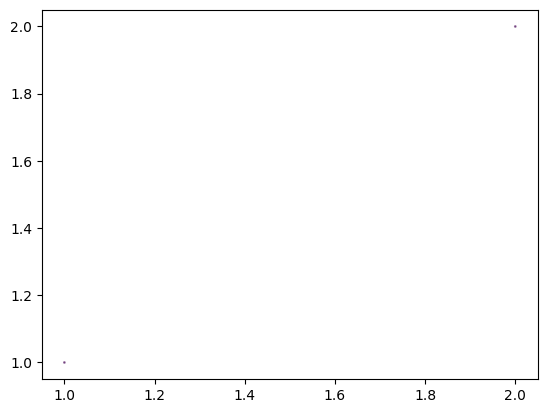

In [12]:
fig, ax = plt.subplots()
ax.scatter([1, 2], [1, 2], c=[1, 1], s=[1, 1], alpha=0.5)

ax.xaxis

plt.show()

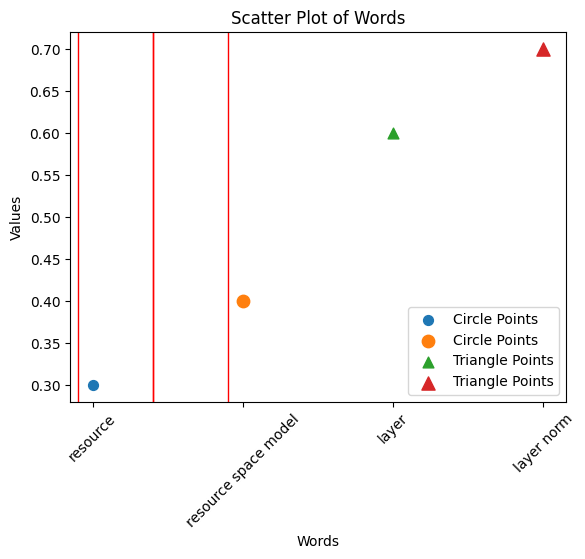

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 横坐标单词列表
words = ['resource', 'resource space model', 'layer', 'layer norm']
# 模拟纵坐标的值（这里示例中对应四个值，范围在0 - 1之间，你可按需替换真实数据）
y_values = [0.3, 0.4, 0.6, 0.7]
# 模拟标记形状，这里用 'o' 表示圆形，'^' 表示三角形，与单词对应，你可按需调整顺序等
markers = ['o', 'o', '^', '^']
# 模拟散点大小，这里示例四个不同大小的值，对应四个数据点，你可按实际数值情况替换
sizes = [50, 80, 60, 90]
# 用于图例的标签列表，这里细化为包含形状和单词的更详细标签，方便区分同一个单词不同标记的情况
labels = ['Circle - resource', 'Circle - resource space model', 'Triangle - layer', 'Triangle - layer norm']

# 用于存储已绘制单词对应的散点信息，方便后续处理图例重复标签问题
plotted_words = {}
for i in range(len(words)):
    word = words[i]
    if word not in plotted_words:
        plotted_words[word] = []
    plotted_words[word].append((markers[i], y_values[i], sizes[i], labels[i]))

# 先绘制散点，处理同一个单词有不同标记的情况
handles = []
for word in plotted_words:
    first_label = None
    for marker, y_value, size, label in plotted_words[word]:
        scatter = plt.scatter(word, y_value, marker=marker, s=size, label=label)
        if first_label is None:
            first_label = label
            handles.append(scatter)

# 设置横坐标标签旋转角度，防止文字重叠，方便查看
plt.xticks(rotation=45)
# 添加标题
plt.title('Scatter Plot of Words')
# 添加横纵坐标标签
plt.xlabel('Words')
plt.ylabel('Values')
# 显示图例，只显示每个单词第一次出现对应的散点的标签，避免重复
plt.legend(handles=handles)

# 绘制矩形框来圈起分组的词，这里通过指定坐标范围来框选，坐标需要根据实际布局微调
# 第一组词'resource'和'resource space model'的框选
rect1 = patches.Rectangle((-0.1, -0.1), 0.5, 1.2, linewidth=1, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect1)

# 第二组词 'layer'和'layer norm'的框选
rect2 = patches.Rectangle((0.4, -0.1), 0.5, 1.2, linewidth=1, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect2)

# 显示图形
plt.show()

In [5]:
delta1[:-1], delta1[1:]

array([ 7.95784997e-03,  9.36855330e-03,  3.84479447e-02,  7.39896710e-05,
       -1.08164896e-02,  9.10981137e-03,  6.86332642e-03,  2.28788481e-02,
        1.76029477e-02, -5.36067893e-03,  1.14332845e-02,  2.02460457e-02,
        2.22421277e-02, -1.19306003e-02, -5.33467951e-02, -4.30502710e-02,
       -4.80443394e-02,  4.50583005e-02, -2.85671032e-02, -1.87476624e-02,
        6.32097197e-03, -1.22784590e-02,  3.62546936e-02,  1.84722608e-02,
        2.44958518e-02, -1.58120290e-02,  1.13663664e-02,  2.77476728e-02,
        6.84713836e-03, -5.73888092e-03, -1.65512266e-02,  3.85896439e-03,
        2.09746258e-02,  2.39796137e-02, -5.45256270e-04,  4.96593786e-03,
       -2.67531528e-02,  2.14530892e-04, -7.57846572e-03, -5.89294719e-03,
       -3.00452200e-02,  6.15632892e-03,  5.97014925e-03,  1.81879918e-02,
        1.01494875e-02,  5.79884884e-03,  1.44278110e-02, -1.42085420e-02,
        2.55444245e-03, -1.57288657e-02, -9.09643084e-03,  2.04322889e-04,
       -4.13377497e-02, -

## Phrase level Figure

In [145]:
# 对比TFIDF, 在前50%占比情况，词跨度, action_link_count
import re

phrase_tf, phrase_tf_idf, phrase_front, _phrase_span, phrase_action_counter, phrase_incoming_action_counter = {}, {}, {}, {}, {}, {}
for sentence_index, sentence in enumerate(mainMaterial.sentences):
    phrases = set()
    for pre, ind, rtype, post, _ in sentence.links:
        phrases.update([pre, ind, post])

        if rtype == LinkType.Action:
            phrase_action_counter[pre] = phrase_action_counter.get(pre, 0) + 1
            phrase_incoming_action_counter[post] = phrase_incoming_action_counter.get(post, 0) + 1
    
    for phrase in phrases:
        if len(phrase) < 4:
            continue

        phrase = ' '.join([normalize_word(word) for word in phrase.split(' ')])

        phrase_tf[phrase] = phrase_tf.get(phrase, 0) + 1
        phrase_tf_idf[phrase] = phrase_tf.get(phrase, 0) + get_idf_value(phrase)

        # 前20%
        if sentence_index < len(mainMaterial.sentences) / 5:
            phrase_front[phrase] = phrase_front.get(phrase, 0) + 1
        
        if phrase not in _phrase_span:
            _phrase_span[phrase] = [sentence_index, sentence_index]
        else:
            _phrase_span[phrase][1] = sentence_index


    for pre, ind, rtype, post, _ in sentence.links:
        if rtype == LinkType.Action:
            action_counter[pre] = action_counter.get(pre, 0) + 1
            incoming_action_counter[post] = incoming_action_counter.get(post, 0) + 1

phrase_span = {
    word: values[1] - values[0]
    for word, values in _phrase_span.items()
}

In [146]:
(norm_phrase_tf, norm_phrase_tf_idf, norm_phrase_front, norm_phrase_span, norm_phrase_action_counter, norm_phrase_incoming_action_counter), common_top = _sort_norm([phrase_tf, phrase_tf_idf, phrase_front, phrase_span, phrase_action_counter, phrase_incoming_action_counter], 20)


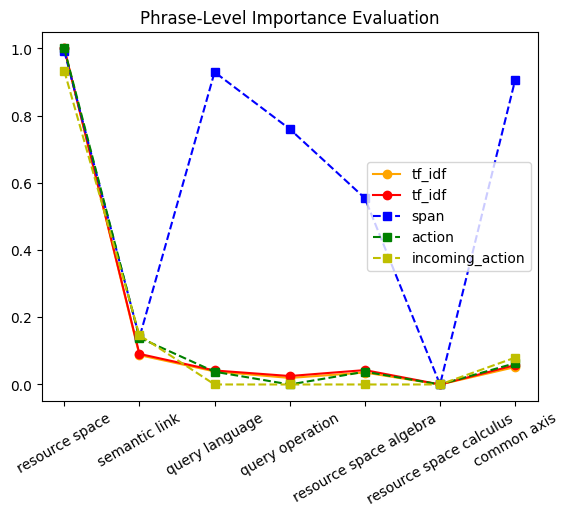

In [147]:
import matplotlib.pyplot as plt
import numpy as np

# 生成横坐标数据
x = np.arange(0, 10, 1)

# TODO: 选一些例子，更能凸显action link的优势
# TODO: semantic node也可以计算frequency, span等 
core_words = [
    # 'rsm',
    # 'semantic link network',
    'resource space',
    'semantic link',
    'query language',
    # 'relational tables',
    # 'union view',
    # 'resource class hierarchy',
    'query operation',
    'resource space algebra',
    'resource space calculus',
    'common axis',
    # 'critical dimension',
    # 'resource space model storage',
    # 'rsm storage',
    # 'gossip network',
    # 'point query',
    # 'resource query',
    # 'resource modification',
    # 'probabilistic resource space',
]

# 生成纵坐标数据
tf_y = [norm_phrase_tf.get(w, 0) for w in core_words]
tf_idf_y = [norm_phrase_tf_idf.get(w, 0) for w in core_words]
front_y = [norm_phrase_front.get(w, 0) for w in core_words]
span_y = [norm_phrase_span.get(w, 0) for w in core_words]
action_y = [norm_phrase_action_counter.get(w, 0) for w in core_words]
incoming_action_y = [norm_phrase_incoming_action_counter.get(w, 0) for w in core_words]


# 绘制第一条折线
plt.plot(core_words, tf_y, color='orange', marker='o', linestyle='-', label='tf_idf')
plt.plot(core_words, tf_idf_y, color='r', marker='o', linestyle='-', label='tf_idf')
# 绘制第二条折线
plt.plot(core_words, span_y, color='b', marker='s', linestyle='--', label='span')
plt.plot(core_words, action_y, color='g', marker='s', linestyle='--', label='action')
plt.plot(core_words, incoming_action_y, color='y', marker='s', linestyle='--', label='incoming_action')

plt.xticks(rotation=30)

# 添加图例
plt.legend()

# 设置x轴标签
# plt.xlabel('x')
# 设置y轴标签
# plt.ylabel('y')
# 设置标题
plt.title('Phrase-Level Importance Evaluation')

plt.savefig('figs/phrase_level_importance.png', dpi=300, bbox_inches='tight')


# 显示图形
plt.show()

In [104]:
sorted(norm_action_counter.items(), key=lambda x: -x[1])[:30]

[('resource space', 1.0),
 ('resource', 0.9620253164556962),
 ('node', 0.569620253164557),
 ('peer', 0.4936708860759494),
 ('operation', 0.3924050632911392),
 ('user', 0.379746835443038),
 ('axis', 0.35443037974683544),
 ('coordinate', 0.27848101265822783),
 ('person', 0.24050632911392406),
 ('network', 0.24050632911392406),
 ('one', 0.22784810126582278),
 ('chapter', 0.20253164556962025),
 ('query', 0.189873417721519),
 ('example', 0.17721518987341772),
 ('semantic', 0.16455696202531644),
 ('space', 0.16455696202531644),
 ('point', 0.16455696202531644),
 ('theorem', 0.16455696202531644),
 ('system', 0.1518987341772152),
 ('tree', 0.1518987341772152),
 ('approach', 0.13924050632911392),
 ('application', 0.13924050632911392),
 ('semantic link', 0.13924050632911392),
 ('external relationship', 0.13924050632911392),
 ('object', 0.12658227848101267),
 ('best algorithm', 0.12658227848101267),
 ('neighbor', 0.12658227848101267),
 ('resource indice', 0.12658227848101267),
 ('designer', 0.1139

{'ability',
 'abstraction',
 'advantage',
 'algorithm',
 'answer',
 'application',
 'application scope',
 'approach',
 'area',
 'attribute',
 'authority',
 'axis',
 'axis name',
 'book',
 'case',
 'category',
 'cave content',
 'check clause',
 'citation relation',
 'classification',
 'classification method',
 'classification semantic',
 'clause',
 'common ancestor',
 'common axis',
 'community',
 'comparison',
 'complex object',
 'computer',
 'concept',
 'consistency',
 'content',
 'coordinate',
 'coordinate setting',
 'coordinate tree',
 'customer',
 'database',
 'datum',
 'definition',
 'designer',
 'different category',
 'different classification method',
 'dimension',
 'disk',
 'domain ontology',
 'effect',
 'efficiency',
 'eleven category',
 'example',
 'existing resource space',
 'experience',
 'external feature',
 'fig.1.16',
 'file',
 'following abstract concept',
 'following command',
 'following statement',
 'four operation',
 'function',
 'good',
 'human behavior mode',
 'id

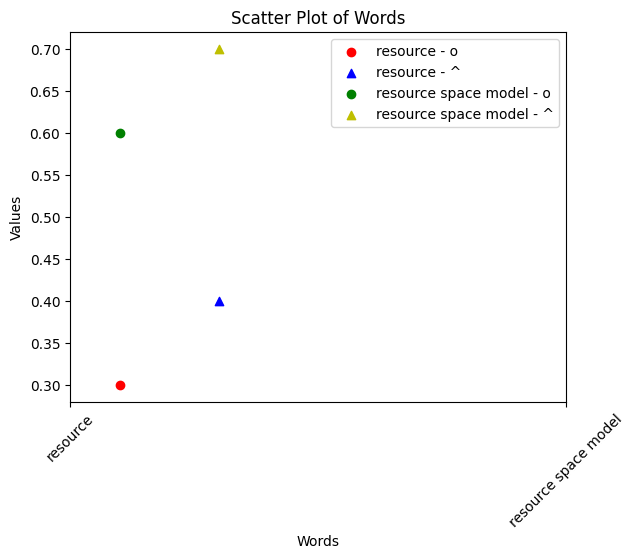

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 横坐标单词列表
words = ['resource', 'resource space model']
# 模拟每个单词对应的两组纵坐标值，每组包含两个值，你可按需替换真实数据
y_values = [[0.3, 0.4], [0.6, 0.7]]
# 模拟标记形状，这里用 'o' 表示圆形，'^' 表示三角形，与单词对应，你可按需调整顺序等
markers = [['o', '^'], ['o', '^']]
# 模拟散点颜色，这里使用两种不同颜色示例，你可按需替换
colors = [['r', 'b'], ['g', 'y']]
# 偏移量，用于在横坐标方向上区分同一个横坐标下的两个点，可根据实际效果调整大小
offset = 0.05

for i in range(len(words)):
    for j in range(len(y_values[i])):
        # 根据是第一个还是第二个点决定水平偏移方向，第一个点向左偏移，第二个点向右偏移
        if j == 0:
            x_pos = 0.1
        else:
            x_pos = 0.3
            # x_pos = np.where(words == words[i])[0][0] + offset
        plt.scatter(x_pos, y_values[i][j], marker=markers[i][j], c=colors[i][j], label=f"{words[i]} - {markers[i][j]}")

# 设置横坐标标签旋转角度，防止文字重叠，方便查看
plt.xticks(np.arange(len(words)), words, rotation=45)
# 添加标题
plt.title('Scatter Plot of Words')
# 添加横纵坐标标签
plt.xlabel('Words')
plt.ylabel('Values')
# 显示图例
plt.legend()
# 显示图形
plt.show()

In [212]:
preface_sentences = []; normal_sentences = []
for sentence in materials[0].sentences:
    if sentence.position.startswith('preface'):
        preface_sentences.append(sentence)
    else:
        normal_sentences.append(sentence)

# 计算preface的重要词
tf_idf_node_counter = {}; tf_idf_counter = {}
active_node_counter = {}; active_counter = {}
# for sentence in preface_sentences:

def norm_node(n):
    mapper = {
        'proces': 'process',
        'expressivenes': 'expressiveness',
        'completenes': 'completeness',
    }
    return mapper.get(n, n)

preface_nodes = set()
for sentence in preface_sentences:
    for pre, ind, rtype, post, _ in sentence.links:
        pre, post = norm_node(pre), norm_node(post)
        preface_nodes.update([pre, post])

for sentence in normal_sentences:
    for pre, ind, rtype, post, _ in sentence.links:
        pre, post = norm_node(pre), norm_node(post)

        tf_idf_node_counter[pre] = tf_idf_node_counter.get(pre, 0) + get_idf_value(pre)
        tf_idf_node_counter[post] = tf_idf_node_counter.get(post, 0) + get_idf_value(post)

        if rtype.value == 'action':
            active_node_counter[pre] = active_node_counter.get(pre, 0) + 1
            for word in pre.split(' '):
                active_counter[word] = active_counter.get(word, 0) + 1

        for word in (pre.split(' ') + post.split(' ')):
            tf_idf_counter[word] = tf_idf_counter.get(word, 0) + get_idf_value(word)

# active_node_counter归一化
def norm_dict(data, max_range = 100):
    _min, _max = min(data.values()), max(data.values())
    return {k: max_range * (v - _min) / (_max - _min) for k, v in data.items()}

active_node_counter = norm_dict(active_node_counter)
active_counter = norm_dict(active_counter)

# 计算词在正文中出现的位置，100个位置
normal_links = [link for sentence in normal_sentences for link in sentence.links]

node_position_counter = {}; word_position_counter = {}
for index, link in enumerate(normal_links, 1):
    # position = ((30 * index) // len(normal_links) + 1) / 100
    budget_count = 100
    position = 100 * (index // (len(normal_links) / budget_count)) / budget_count

    pre, ind, rtype, post, _ = link

    node_position_counter[pre] = node_position_counter.get(pre, {})
    node_position_counter[pre][position] = node_position_counter[pre].get(position, 0) + 1
    node_position_counter[post] = node_position_counter.get(post, {})
    node_position_counter[post][position] = node_position_counter[post].get(position, 0) + 1

    for word in (pre.split(' ') + post.split(' ')):
        word_position_counter[word] = word_position_counter.get(word, {})
        word_position_counter[word][position] = word_position_counter[word].get(position, 0) + 1


In [202]:
preface_nodes

{'2006dfa11970',
 'advanced distributed application',
 'algebra',
 'also basic method',
 'applica tion',
 'approach',
 'autonomy',
 'bird',
 'book',
 'calculus',
 'category',
 'chao',
 'characteristic',
 'china',
 'china knowledge grid research group',
 'china knowledge grid research group help',
 'classification',
 'completenes',
 'complexity',
 'constraint',
 'content',
 'cooperation',
 'coordinate',
 'correctnes',
 'database',
 'database model',
 'decentralized resource space',
 'design',
 'development method',
 'different',
 'dimension',
 'discrete',
 'distribution',
 'effective management',
 'efficiency',
 'erlin yao',
 'expressive power',
 'feather',
 'following content',
 'framework project gredia',
 'fundamental concept',
 'future interconnection environment',
 'general methodology',
 'general resource space model',
 'human being',
 'important contribution',
 'index',
 'integration',
 'international cooperation program',
 'ist',
 'liang feng',
 'method',
 'methodology',
 'minis

In [ ]:
important_words = '''resource
space
query
dimension
semantic
operation
web
coordinate
knowledge
grid
'''
not_important_words = '''
content
model
application
theory
network
complexity
distribution
normalization
research
environment
'''

important_words = ['resource']

In [59]:
preface_sentences = []; normal_sentences = []
for sentence in materials[0].sentences:
    if sentence.position.startswith('preface'):
        preface_sentences.append(sentence)
    else:
        normal_sentences.append(sentence)

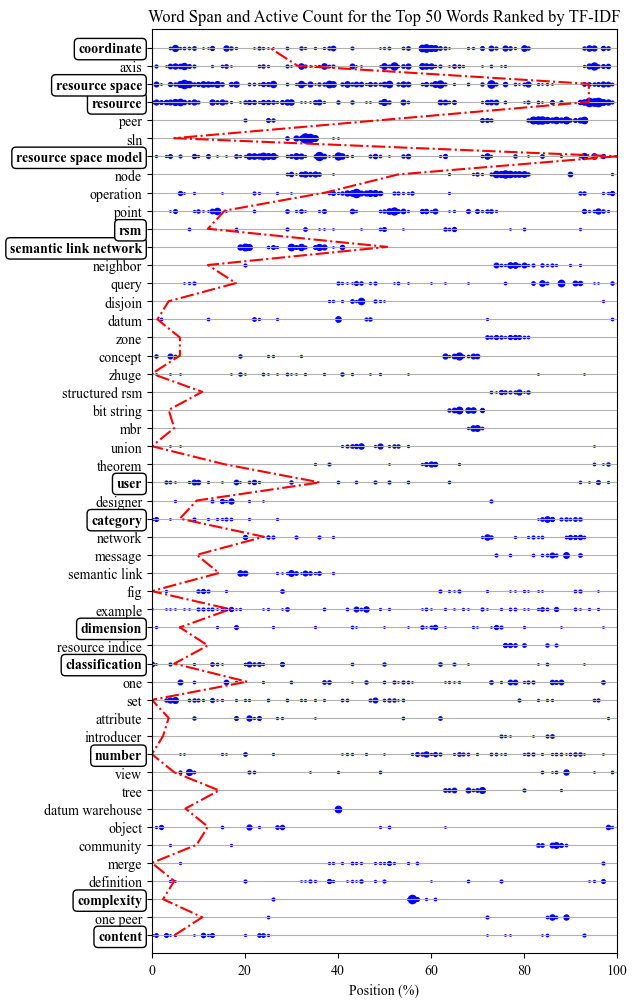

In [213]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.figure(figsize=(6, 12))
plt.rcParams['font.family'] = 'Times New Roman'

# 横坐标单词列表
# words = ['resource', 'resource space model', 'layer', 'layer norm']
# 模拟纵坐标的值（这里示例中对应四个值，范围在0 - 1之间，你可按需替换真实数据）
# y_values = [0.3, 0.4, 0.6, 0.7]
# 模拟标记形状，这里用 'o' 表示圆形，'^' 表示三角形，与单词对应，你可按需调整顺序等
# markers = ['o', 'o', '^', '^']
# 模拟散点大小，这里示例四个不同大小的值，对应四个数据点，你可按实际数值情况替换

nodes = [w[0] for w in sorted(tf_idf_node_counter.items(), key=lambda x: -x[1])][:50][::-1]
for node in nodes:
    if node not in node_position_counter: continue
    for position, value in node_position_counter[node].items():
        if value == 0: continue
        plt.scatter(position, node, marker='o', s=value, c='blue', alpha=1)
    # plt.scatter(words[i], y_values[i], marker='o', s=sizes[i], label=labels[i])
    # plt.scatter(words[i], y_values[i] + 0.2, marker=markers[i], s=sizes[i], label=labels[i])
plt.plot([active_node_counter.get(node, 0) for node in nodes], nodes, '-.', color='red')

# 设置横坐标标签旋转角度，防止文字重叠，方便查看
# plt.xticks(rotation=45)
# 添加标题
plt.title('Word Span and Active Count for the Top 50 Words Ranked by TF-IDF')
# 添加横纵坐标标签
plt.xlabel('Position (%)')
# plt.ylabel('Values')
# 显示图例
# plt.legend()

plt.grid(axis='y')
plt.xlim(0, 100)
plt.ylim(-1, 50)

# 绘制矩形框来圈起分组的词，这里通过指定坐标范围来框选，坐标需要根据实际布局微调
# 第一组词'resource'和'resource space model'的框选
# rect1 = patches.Rectangle((-0.1, -0.1), 0.5, 1.2, linewidth=1, edgecolor='r', facecolor='none')
# plt.gca().add_patch(rect1)

# # 第二组词 'layer'和'layer norm'的框选
# rect2 = patches.Rectangle((0.4, -0.1), 0.5, 1.2, linewidth=1, edgecolor='r', facecolor='none')
# plt.gca().add_patch(rect2)

ax = plt.gca()
# 获取x轴刻度标签
xticklabels = ax.get_yticklabels()
for i, label in enumerate(xticklabels):
    if label.get_text() in preface_nodes:
        label.set_fontweight('bold')
        label.set_bbox(dict(facecolor='white', edgecolor='black', boxstyle='round'))
        # label.set_text(text_obj, underline=True)


# 显示图形
plt.savefig('figs/top50_idf_span_active.png', dpi=300, bbox_inches='tight')
plt.show()

In [209]:
plt.savefig('figs/top50_idf_span_active.png')

<Figure size 640x480 with 0 Axes>

C:\Users\lee\AppData\Local\Temp\ipykernel_23096\2408725257.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=data_df, x="Position", y="Node", size="Value", sizes=(10, 200), palette="Blues", legend=False)


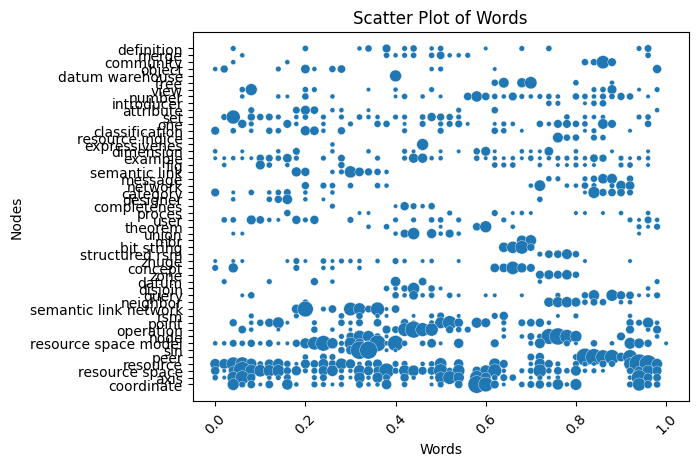

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt

# 假设这里的tf_idf_node_counter和node_position_counter是已经定义好的字典类型数据，包含了绘图所需的数据
# 例如tf_idf_node_counter可能是类似 {节点名: 某个计数} 的结构，node_position_counter是类似 {节点名: {位置: 对应数值}} 的结构

# 初始化一个空的数据集列表，用于后续构造适合seaborn绘图的数据格式（DataFrame）
data_list = []

# 从tf_idf_node_counter中取出前50个节点（按对应值从大到小排序后取前50），并逆序（为了保持某种顺序要求，具体看你原本的逻辑意图）
top_50_nodes = [w[0] for w in sorted(tf_idf_node_counter.items(), key=lambda x: -x[1])][:50][::-1]
for node in top_50_nodes:
    if node not in node_position_counter:
        continue
    for position, value in node_position_counter[node].items():
        if value == 0:
            continue
        # 将每个符合条件的数据点添加到data_list中，构造包含节点、位置、数值这三列的数据格式
        data_list.append({"Node": node, "Position": position, "Value": value})

# 将数据列表转换为pandas的DataFrame格式，seaborn可以很方便地使用DataFrame进行绘图
import pandas as pd
data_df = pd.DataFrame(data_list)

# 使用seaborn的scatterplot绘制散点图，指定x为Position，y为Node，点的大小根据Value来设置，颜色统一设为蓝色
sns.scatterplot(data=data_df, x="Position", y="Node", size="Value", sizes=(10, 200), palette="Blues", legend=False)

# 设置横坐标标签旋转角度，防止文字重叠，方便查看
plt.xticks(rotation=45)
# 添加标题
plt.title('Scatter Plot of Words')
# 添加横纵坐标标签
plt.xlabel('Words')
plt.ylabel('Nodes')

# 显示图形
plt.show()

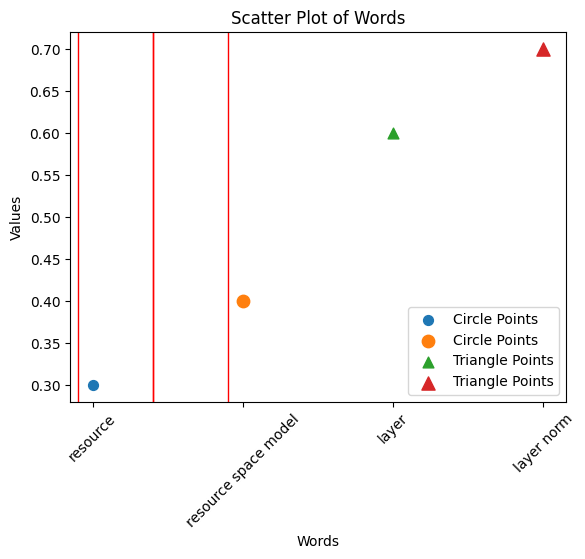

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 横坐标单词列表
words = ['resource', 'resource space model', 'layer', 'layer norm']
# 模拟纵坐标的值（这里示例中对应四个值，范围在0 - 1之间，你可按需替换真实数据）
y_values = [0.3, 0.4, 0.6, 0.7]
# 模拟标记形状，这里用 'o' 表示圆形，'^' 表示三角形，与单词对应，你可按需调整顺序等
markers = ['o', 'o', '^', '^']
# 模拟散点大小，这里示例四个不同大小的值，对应四个数据点，你可按实际数值情况替换
sizes = [50, 80, 60, 90]
# 用于图例的标签列表
labels = ['Circle Points', 'Circle Points', 'Triangle Points', 'Triangle Points']

for i in range(len(words)):
    plt.scatter(words[i], y_values[i], marker=markers[i], s=sizes[i], label=labels[i])

# 设置横坐标标签旋转角度，防止文字重叠，方便查看
plt.xticks(rotation=45)
# 添加标题
plt.title('Scatter Plot of Words')
# 添加横纵坐标标签
plt.xlabel('Words')
plt.ylabel('Values')
# 显示图例
plt.legend()

# 绘制矩形框来圈起分组的词，这里通过指定坐标范围来框选，坐标需要根据实际布局微调
# 第一组词'resource'和'resource space model'的框选
rect1 = patches.Rectangle((-0.1, -0.1), 0.5, 1.2, linewidth=1, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect1)

# 第二组词 'layer'和'layer norm'的框选
rect2 = patches.Rectangle((0.4, -0.1), 0.5, 1.2, linewidth=1, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect2)

# 显示图形
plt.show()

phrase

## 依存关系图

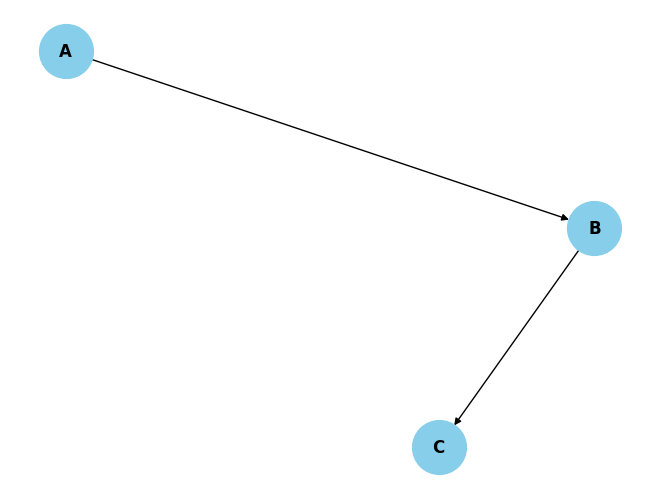

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
# 创建一个有向图
G = nx.DiGraph()
# 添加节点
G.add_nodes_from(['A', 'B', 'C'])
# 添加边，表示依存关系
G.add_edge('A', 'B')
G.add_edge('B', 'C')
# 绘制图形
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1500, node_color='skyblue', font_size=12, font_weight='bold')
plt.show()

## Polish-P/R Curve

load links from rsm: 100%|██████████| 10668/10668 [00:00<00:00, 347163.29it/s]
load file rsm: 0it [00:00, ?it/s]

load file rsm: 3359it [00:00, 1834700.76it/s]


[{'Recall': 0.25, 'Precision': 1.0, 'Model': 'Model 1'}, {'Recall': 0.5, 'Precision': 1.0, 'Model': 'Model 1'}, {'Recall': 0.75, 'Precision': 1.0, 'Model': 'Model 1'}, {'Recall': 1.0, 'Precision': 1.0, 'Model': 'Model 1'}, {'Recall': 1.0, 'Precision': 0.8, 'Model': 'Model 1'}, {'Recall': 1.0, 'Precision': 0.6666666666666666, 'Model': 'Model 1'}, {'Recall': 0.25, 'Precision': 1.0, 'Model': 'Model 2'}, {'Recall': 0.5, 'Precision': 1.0, 'Model': 'Model 2'}, {'Recall': 0.75, 'Precision': 1.0, 'Model': 'Model 2'}, {'Recall': 1.0, 'Precision': 1.0, 'Model': 'Model 2'}, {'Recall': 1.0, 'Precision': 0.8, 'Model': 'Model 2'}, {'Recall': 1.0, 'Precision': 0.6666666666666666, 'Model': 'Model 2'}]


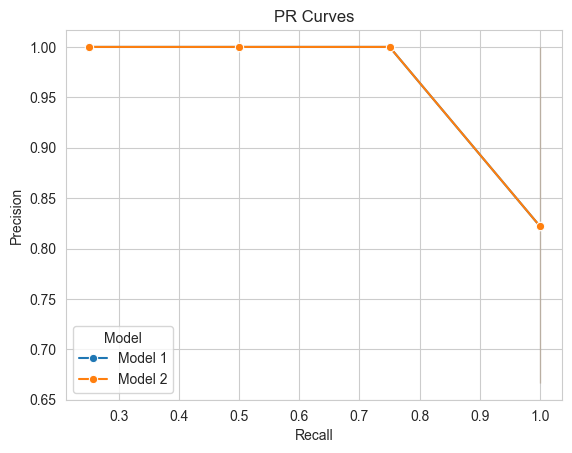

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def calculate_precision_recall(y_true, y_scores):
    """
    计算不同阈值下的精确率和召回率
    :param y_true: 真实标签，二元数组
    :param y_scores: 预测得分，数组
    :return: precision 精确率数组，recall 召回率数组
    """
    sorted_indices = np.argsort(y_scores)[::-1]
    y_true_sorted = y_true[sorted_indices]
    num_positive = np.sum(y_true)
    precision = []
    recall = []
    true_positive_count = 0
    for i in range(len(y_true_sorted)):
        if y_true_sorted[i] == 1:
            true_positive_count += 1
        precision.append(true_positive_count / (i + 1))
        recall.append(true_positive_count / num_positive)
    return np.array(precision), np.array(recall)


# 示例数据，这里假设有两组不同的预测结果
y_true_1 = np.array([1, 0, 1, 1, 0, 1])  # 第一组真实标签，1 表示正例，0 表示反例
y_scores_1 = np.array([0.8, 0.3, 0.6, 0.7, 0.2, 0.9])  # 第一组预测得分

y_true_2 = np.array([1, 1, 0, 1, 1, 0])  # 第二组真实标签
y_scores_2 = np.array([0.7, 0.8, 0.4, 0.6, 0.5, 0.3])  # 第二组预测得分


precision_1, recall_1 = calculate_precision_recall(y_true_1, y_scores_1)
precision_2, recall_2 = calculate_precision_recall(y_true_2, y_scores_2)


def plot_pr_curves(precisions, recalls, labels):
    """
    绘制多条 PR 曲线并添加图例
    :param precisions: 精确率列表，包含多个精确率数组
    :param recalls: 召回率列表，包含多个召回率数组
    :param labels: 每条曲线的标签列表
    """
    data = []
    for precision, recall, label in zip(precisions, recalls, labels):
        data.extend([{'Recall': r, 'Precision': p, 'Model': label} for r, p in zip(recall, precision)])
        
    print(data)
    
    data = pd.DataFrame(data)
    sns.set_style('whitegrid')
    sns.lineplot(x='Recall', y='Precision', hue='Model', data=data, marker='o')
    plt.title('PR Curves')
    plt.show()


# 将计算得到的精确率和召回率放入列表中
precisions = [precision_1, precision_2]
recalls = [recall_1, recall_2]
labels = ['Model 1', 'Model 2']

plot_pr_curves(precisions, recalls, labels)

In [135]:
import nltk
import tqdm
from summarization_framework import word_limit
from evaluation import calculate_scores

def p_r_plot(predictions, reference):
    _p_r_plot(predictions, reference, 1)
    _p_r_plot(predictions, reference, 2)
    _p_r_plot(predictions, reference, 'L')

def _p_r_plot(predictions, reference, rouge_n):
    '''
    predictions: {model_name: text}
    '''
    data = []
    for model_name, prediction in predictions.items():
        prediction = word_limit(prediction, 1250)
        
        pred_summary = ''
        precisions, recalls = [], []
        words = nltk.word_tokenize(prediction)
        step = 20
        for sent in tqdm.tqdm([words[i:i+step] for i in range(0, len(words), step)]):
            pred_summary += ' '.join(sent) + ' '
            mapper = calculate_scores(pred_summary, reference)
            precision = mapper[f'rouge{rouge_n}'][0]
            recall = mapper[f'rouge{rouge_n}'][1]
            
            # if model_name == 'W-SLN' and rouge_n == 1:
            #     if recall < 62 and precision < 40:
            #         continue
            
            data.append({
                'Recall': recall,
                'Precision': precision,
                'Model': model_name,
            })
        
    data = pd.DataFrame(data)
    sns.set_style('whitegrid')
    sns.set_theme(style="darkgrid")
    
    palette = ['red'] + ['purple'] + sns.color_palette("husl", 10)[2:len(predictions)]
    print(palette)
    palette = palette[:len(predictions)]
    
    sns_plot = sns.lineplot(x="Recall", y="Precision",
            hue="Model",
            # style="event",
            data=data,
            palette=palette)
    # sns.lineplot(x='Recall', y='Precision', hue='Model', data=data, marker='o')
    
    lines = sns_plot.lines
    # 修改线的样式
    for model_name, line in (zip(predictions.keys(), lines)):
        if model_name.startswith('W-SLN'):
            line.set_linewidth(3)
            
        if model_name in ['TextRank', 'LexRank', 'LSA', 'Luhn']:
            line.set_linestyle('--')  # 线的样式为虚线
        
        if model_name in ['BART', 'Llama3.2-1B', 'Llama3.2-3B', 'Llama3.2-8B']:
            line.set_linestyle(':')  # 线的样式为.-
            # line.set_alpha(0.7)  # 透明度为 0.7
    
    plt.title(f'ROUGE-{rouge_n} Precision-Recall Curve')
    plt.legend(fontsize='x-small')
    sns_plot.set_ylim(0, 100)
    sns_plot.set_xlim(left=0)

    
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['axes.labelsize'] = 14  # 轴标签字体大小
    plt.rcParams['axes.labelweight'] = 'bold'  # 轴标签字体加粗
    plt.rcParams['axes.titleweight'] = 'bold'  # 标题字体加粗
    plt.rcParams['axes.titlesize'] = 16
    
    sns_plot.figure.savefig(f'figs/pr_curve_rouge{rouge_n}.png', dpi=300)
    plt.close()
    # plt.show()

In [134]:
from summarization_framework import load_rsm

materials, references, output_base_dir = load_rsm()

wsln_output_name = '250107_161549'

wsln_text = (output_base_dir / wsln_output_name / 'rsm').read_text()

prediction_mapper = {}
prediction_mapper['W-SLN'] = (output_base_dir / '250107_161549' / 'rsm').read_text()
prediction_mapper['W-SLN-Polish'] = (output_base_dir / '250107_161549-polished' / 'rsm').read_text()
for (model_name, dir_name) in [
        ('Luhn', 'luhn'),
        ('TextRank', 'textrank'),
        ('LexRank', 'lexrank'),
        ('LSA', 'lsa'),
        ('BART', 'bart'),
        ('Llama3.2-1B', 'llama_3d2_1b'),
        ('Llama3.2-3B', 'llama_3d2_3b'),
        ('Llama3.2-8B', 'llama_3d1_8b')
    ]:
    prediction_mapper[model_name] = (output_base_dir.parent / f'output/{dir_name}/rsm').read_text()

p_r_plot(prediction_mapper, references[0])

load links from rsm: 100%|██████████| 10668/10668 [00:00<00:00, 100001.87it/s]
load file rsm: 3359it [00:00, 460715.08it/s]
100%|██████████| 63/63 [00:03<00:00, 17.53it/s]


['red', (0.8616090647292522, 0.536495730113334, 0.19548899031476086), (0.6804189127793346, 0.6151497514677574, 0.19405452111445337), (0.46810256823426105, 0.6699492535792404, 0.1928958739904499), (0.20125317221201128, 0.6907920815379025, 0.47966761189275336), (0.21044753832183283, 0.6773105080456748, 0.6433941168468681), (0.2197995660828324, 0.6625157876850336, 0.7732093159317209), (0.433280341176423, 0.6065273407962815, 0.9585467098271748), (0.8004936186423958, 0.47703363533737203, 0.9579547196007522), (0.962272393509669, 0.3976451968965351, 0.8008274363432775)]


100%|██████████| 63/63 [00:03<00:00, 17.41it/s]


['red', (0.8616090647292522, 0.536495730113334, 0.19548899031476086), (0.6804189127793346, 0.6151497514677574, 0.19405452111445337), (0.46810256823426105, 0.6699492535792404, 0.1928958739904499), (0.20125317221201128, 0.6907920815379025, 0.47966761189275336), (0.21044753832183283, 0.6773105080456748, 0.6433941168468681), (0.2197995660828324, 0.6625157876850336, 0.7732093159317209), (0.433280341176423, 0.6065273407962815, 0.9585467098271748), (0.8004936186423958, 0.47703363533737203, 0.9579547196007522), (0.962272393509669, 0.3976451968965351, 0.8008274363432775)]


100%|██████████| 63/63 [00:03<00:00, 17.25it/s]


['red', (0.8616090647292522, 0.536495730113334, 0.19548899031476086), (0.6804189127793346, 0.6151497514677574, 0.19405452111445337), (0.46810256823426105, 0.6699492535792404, 0.1928958739904499), (0.20125317221201128, 0.6907920815379025, 0.47966761189275336), (0.21044753832183283, 0.6773105080456748, 0.6433941168468681), (0.2197995660828324, 0.6625157876850336, 0.7732093159317209), (0.433280341176423, 0.6065273407962815, 0.9585467098271748), (0.8004936186423958, 0.47703363533737203, 0.9579547196007522), (0.962272393509669, 0.3976451968965351, 0.8008274363432775)]


In [131]:
dir_name

'llama_3d1_8b'

In [53]:
sns.color_palette("husl", 10)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.8616090647292522, 0.536495730113334, 0.19548899031476086),
 (0.6804189127793346, 0.6151497514677574, 0.19405452111445337),
 (0.46810256823426105, 0.6699492535792404, 0.1928958739904499),
 (0.20125317221201128, 0.6907920815379025, 0.47966761189275336),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.2197995660828324, 0.6625157876850336, 0.7732093159317209),
 (0.433280341176423, 0.6065273407962815, 0.9585467098271748),
 (0.8004936186423958, 0.47703363533737203, 0.9579547196007522),
 (0.962272393509669, 0.3976451968965351, 0.8008274363432775)]

In [86]:
wsln_prediction_mapper = {}
# for model in [
#     # '250107_124939',
#     '250107_161549',
#     # '250107_144818',
# ]:
    
wsln_prediction_mapper['W-SLN'] = (output_base_dir / '250107_161549' / 'rsm').read_text()

prompt = '''
As a professional text polisher, you are required to optimize the following text according to the given sequence of conceptual dependencies:

- Input text: <input text>{text}</input text>

The optimization should adhere to the following conditions:

1. Retain the key concepts and literal meanings of the original text.
2. Slightly adjust the sentence order to enhance coherence.
3. Simplify sentences appropriately by removing less important words.
4. The output text should follow the sequence of conceptual dependencies.

The output should only contain the optimized text, without any additional explanations, and should output at least 1250 words in length.
'''
import ollama

polished_text = ollama.chat(model='llama3.1', messages=[{
    'role': 'user',
    'content': prompt.format(text=wsln_prediction_mapper['W-SLN']),},]
)['message']['content']

wsln_prediction_mapper['llama_3d1_8b'] = (output_base_dir.parent / 'output/llama_3d1_8b/rsm').read_text()
wsln_prediction_mapper['polished'] = polished_text

p_r_plot(wsln_prediction_mapper, references[0])

100%|██████████| 63/63 [00:03<00:00, 17.13it/s]


['red', (0.8616090647292522, 0.536495730113334, 0.19548899031476086), (0.6804189127793346, 0.6151497514677574, 0.19405452111445337)]


100%|██████████| 63/63 [00:03<00:00, 17.02it/s]


['red', (0.8616090647292522, 0.536495730113334, 0.19548899031476086), (0.6804189127793346, 0.6151497514677574, 0.19405452111445337)]


100%|██████████| 63/63 [00:03<00:00, 16.91it/s]


['red', (0.8616090647292522, 0.536495730113334, 0.19548899031476086), (0.6804189127793346, 0.6151497514677574, 0.19405452111445337)]


In [92]:
# (output_base_dir / '250107_161549-polished').mkdir()
(output_base_dir / '250107_161549-polished' / 'rsm').write_text(polished_text)

23541

In [82]:
len(nltk.word_tokenize(polished_text))

3508

In [88]:
len(nltk.word_tokenize(polished_text))

3831